In [1]:
# Load all packages we will be using

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as matplot
plt.style.use('fivethirtyeight')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

import warnings 
from sklearn.exceptions import ConvergenceWarning
# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

In [2]:
# Read files onto a DataFrame

data = pd.read_csv('2016 School Explorer.csv')
data = data[pd.notnull(data['Student Achievement Rating'])]
data = data[pd.notnull(data['School Income Estimate'])]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 807 entries, 0 to 1271
Columns: 161 entries, Adjusted Grade to Grade 8 Math 4s - Economically Disadvantaged
dtypes: float64(5), int64(123), object(33)
memory usage: 1021.4+ KB


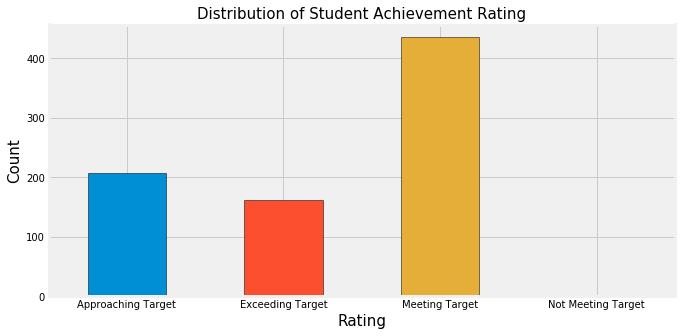

In [4]:
# Distribution of Student Achievement Rating

achieve = data['Student Achievement Rating'].value_counts().sort_index()

achieve.plot.bar(figsize = (10,5), edgecolor = 'k')
plt.xlabel('Rating', size = 15)
plt.title('Distribution of Student Achievement Rating', size = 15)
plt.ylabel('Count', size = 15)
plt.xticks(rotation = 0);

In [5]:
# Check for missing values

null_values = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'Total'})
null_values['Percent'] = null_values['Total'] / len(data)
null_values = null_values.sort_values(['Percent'], ascending=False)
null_values.head(15)

,Total,Percent
Adjusted Grade,807,1.000000
Other Location Code in LCGMS,807,1.000000
New?,807,1.000000
Supportive Environment Rating,10,0.012392
Rigorous Instruction Rating,8,0.009913
Collaborative Teachers Rating,8,0.009913
Effective School Leadership Rating,6,0.007435
Trust Rating,5,0.006196
Strong Family-Community Ties Rating,5,0.006196
Grade 6 ELA 4s - Limited English Proficient,0,0.000000


In [6]:
# Create a list of features that have a percentage

percentage_features = ['Percent of Students Chronically Absent','Rigorous Instruction %','Collaborative Teachers %',
                       'Supportive Environment %','Effective School Leadership %','Strong Family-Community Ties %',
                       'Trust %','Student Attendance Rate','Percent ELL','Percent Asian','Percent Black',
                       'Percent Hispanic','Percent White','Percent Black / Hispanic']

data[percentage_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 807 entries, 0 to 1271
Data columns (total 14 columns):
Percent of Students Chronically Absent    807 non-null object
Rigorous Instruction %                    807 non-null object
Collaborative Teachers %                  807 non-null object
Supportive Environment %                  807 non-null object
Effective School Leadership %             807 non-null object
Strong Family-Community Ties %            807 non-null object
Trust %                                   807 non-null object
Student Attendance Rate                   807 non-null object
Percent ELL                               807 non-null object
Percent Asian                             807 non-null object
Percent Black                             807 non-null object
Percent Hispanic                          807 non-null object
Percent White                             807 non-null object
Percent Black / Hispanic                  807 non-null object
dtypes: object(14)
memory 

In [7]:
# Create a function that removes % symbol and converts it into a float

def p2f(x):
    return float(x.strip('%')) / 100

for i in percentage_features:
    data[i] = data[i].astype(str).apply(p2f)

In [8]:
data['School Income Estimate'].describe()

count             807
unique            807
top       $50,545.80 
freq                1
Name: School Income Estimate, dtype: object

In [9]:
# Remove special characters from School Income Estimate and convert to a number

data['School Income Estimate'] = data['School Income Estimate'].str.replace(',', '')
data['School Income Estimate'] = data['School Income Estimate'].str.replace('$', '')
data['School Income Estimate'] = data['School Income Estimate'].str.replace(' ', '')
data['School Income Estimate'] = data['School Income Estimate'].astype(float)

In [10]:
# Create a list of numerical features

avg_features = ['School Income Estimate','Economic Need Index','Student Attendance Rate','Average ELA Proficiency',
                'Average Math Proficiency']

data[avg_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 807 entries, 0 to 1271
Data columns (total 5 columns):
School Income Estimate      807 non-null float64
Economic Need Index         807 non-null float64
Student Attendance Rate     807 non-null float64
Average ELA Proficiency     807 non-null float64
Average Math Proficiency    807 non-null float64
dtypes: float64(5)
memory usage: 37.8 KB


In [11]:
# Fill empty numerical values with mean

for i in avg_features:
    data[i] = data[i].fillna(data[i].dropna().mean())

In [12]:
# Create a list of rating features

rating_features = ['Supportive Environment Rating','Rigorous Instruction Rating','Collaborative Teachers Rating',
                   'Effective School Leadership Rating','Strong Family-Community Ties Rating','Student Achievement Rating',
                  'Trust Rating']

data[rating_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 807 entries, 0 to 1271
Data columns (total 7 columns):
Supportive Environment Rating          797 non-null object
Rigorous Instruction Rating            799 non-null object
Collaborative Teachers Rating          799 non-null object
Effective School Leadership Rating     801 non-null object
Strong Family-Community Ties Rating    802 non-null object
Student Achievement Rating             807 non-null object
Trust Rating                           802 non-null object
dtypes: object(7)
memory usage: 50.4+ KB


In [13]:
# Fill empty values with mode value of feature

for i in rating_features:
    data[i] = data[i].fillna(data[i].mode()[0])

In [14]:
# Create two new columns that adds the total number of students that took tests (later would not include in the final model)

data['ELA Tests'] = (data['Grade 3 ELA - All Students Tested'] + 
                     data['Grade 4 ELA - All Students Tested'] + 
                     data['Grade 5 ELA - All Students Tested'] + 
                     data['Grade 6 ELA - All Students Tested'] + 
                     data['Grade 7 ELA - All Students Tested'] + 
                     data['Grade 8 ELA - All Students Tested'])

data['Math Tests'] = (data['Grade 3 Math - All Students tested'] + 
                      data['Grade 4 Math - All Students Tested'] + 
                      data['Grade 5 Math - All Students Tested'] + 
                      data['Grade 6 Math - All Students Tested'] + 
                      data['Grade 7 Math - All Students Tested'] + 
                      data['Grade 8 Math - All Students Tested'])


pd.qcut(data['ELA Tests'], 5).value_counts()
pd.qcut(data['Math Tests'], 5).value_counts()

(12.999, 174.0]    163
(435.8, 1161.0]    162
(174.0, 254.0]     162
(323.6, 435.8]     161
(254.0, 323.6]     159
Name: Math Tests, dtype: int64

In [15]:
data.loc[(data['ELA Tests'] >= 0) & (data['ELA Tests'] <= 176), 'ELA Tests'] = 1
data.loc[(data['ELA Tests'] > 176) & (data['ELA Tests'] <= 253), 'ELA Tests'] = 2
data.loc[(data['ELA Tests'] > 253) & (data['ELA Tests'] <= 324), 'ELA Tests'] = 3
data.loc[(data['ELA Tests'] > 324) & (data['ELA Tests'] <= 454), 'ELA Tests'] = 4
data.loc[data['ELA Tests'] > 454, 'ELA Tests'] = 5

data.loc[(data['Math Tests'] >= 0) & (data['Math Tests'] <= 173), 'Math Tests'] = 1
data.loc[(data['Math Tests'] > 173) & (data['Math Tests'] <= 251), 'Math Tests'] = 2
data.loc[(data['Math Tests'] > 251) & (data['Math Tests'] <= 325), 'Math Tests'] = 3
data.loc[(data['Math Tests'] > 325) & (data['Math Tests'] <= 454), 'Math Tests'] = 4
data.loc[data['Math Tests'] > 454, 'Math Tests'] = 5

In [16]:
# One hot encoding

def get_bin(no):
    if no == 0:
        return 0
    elif no > 0 and no <= 0.33 :
        return 1
    elif no > 0.33 and no <= 0.67 :
        return 2
    else:
        return 3


x_features = ['Percent Asian', 'Percent Black','Percent Hispanic','Percent White','Student Attendance Rate',
         'Percent of Students Chronically Absent','Percent ELL']

for i, cn in enumerate(data[x_features]):
    data[cn] = data[cn].apply(lambda x: get_bin(x))

In [17]:
# Change values to dummy variable

data['Community School?'] = pd.get_dummies(data['Community School?'])

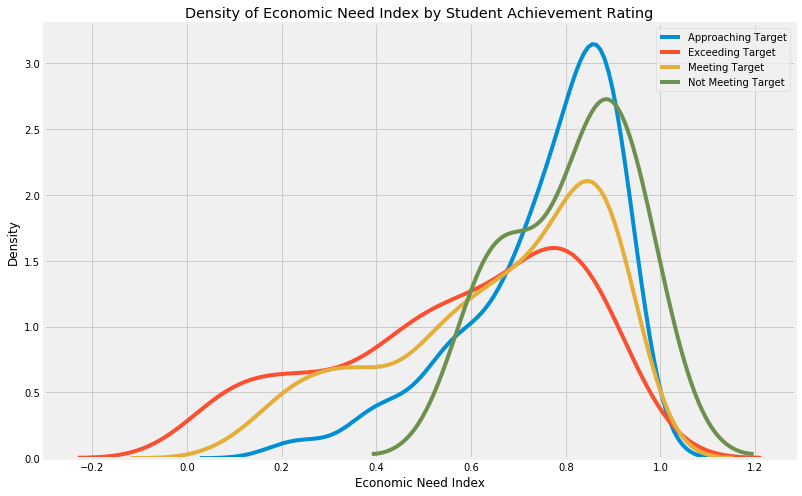

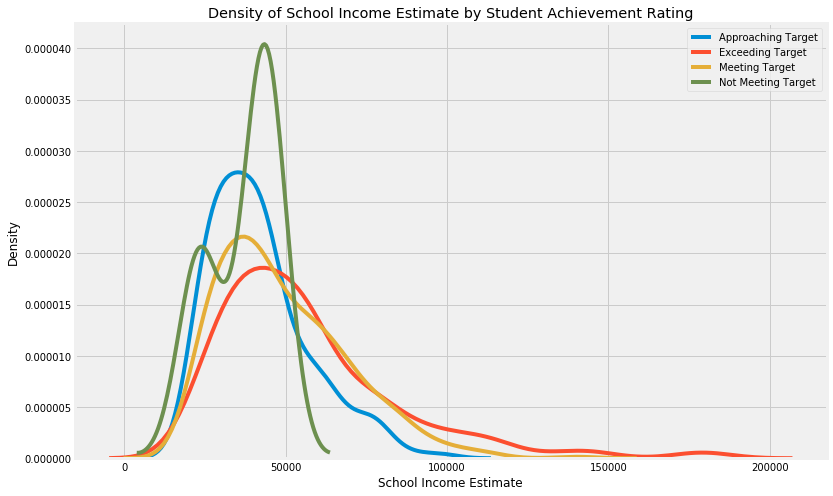

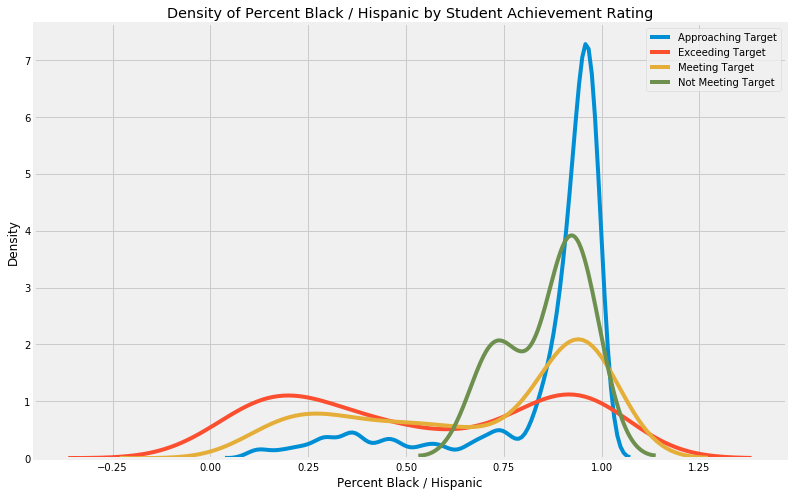

In [18]:
# Density Plots

def density_plot(dataset, feature):
    plt.figure(figsize = (12, 8))
    dataset = dataset[dataset['Student Achievement Rating'].notnull()]
    for item in dataset['Student Achievement Rating'].unique():
        subset = dataset[dataset['Student Achievement Rating'] == item].copy()
        sns.kdeplot(subset[feature].dropna(), 
                    label = '{}'.format(item))

    plt.xlabel(feature); plt.ylabel('Density');
    plt.title('Density of {} by Student Achievement Rating'.format(feature));

density_plot(data, 'Economic Need Index')
density_plot(data, 'School Income Estimate')
density_plot(data, 'Percent Black / Hispanic');

In [19]:
# Change Not Meeting Target to Approaching Target

for feat in rating_features:
    data[feat] = data[feat].replace('Not Meeting Target', 'Approaching Target')

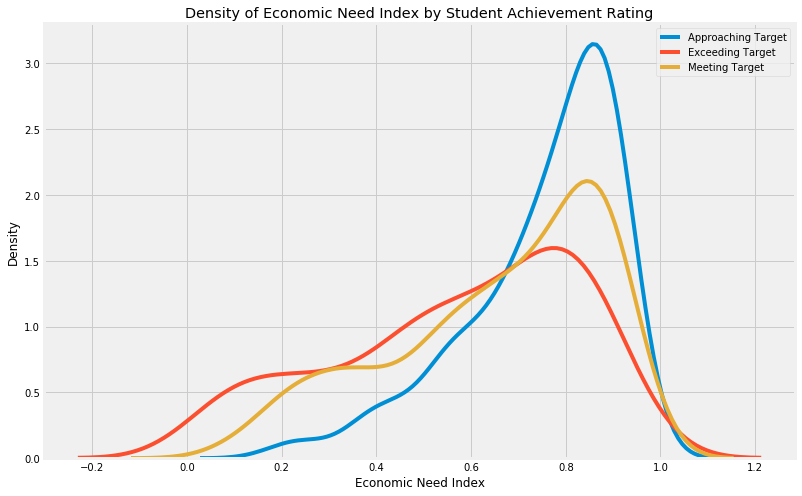

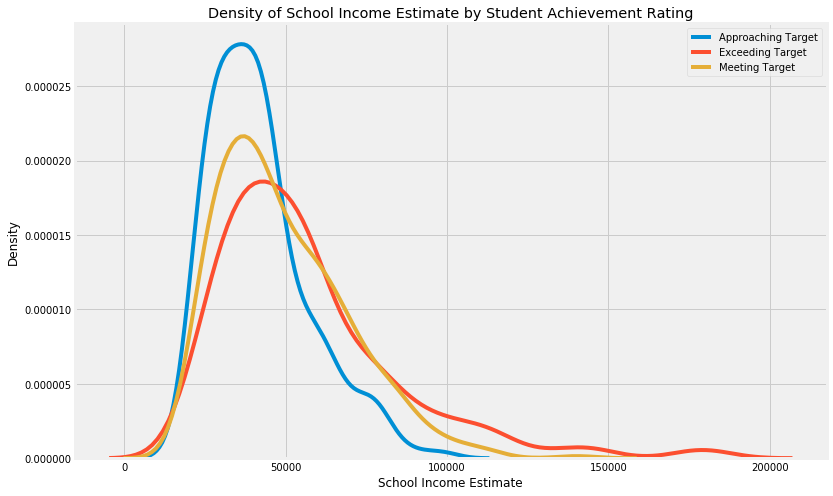

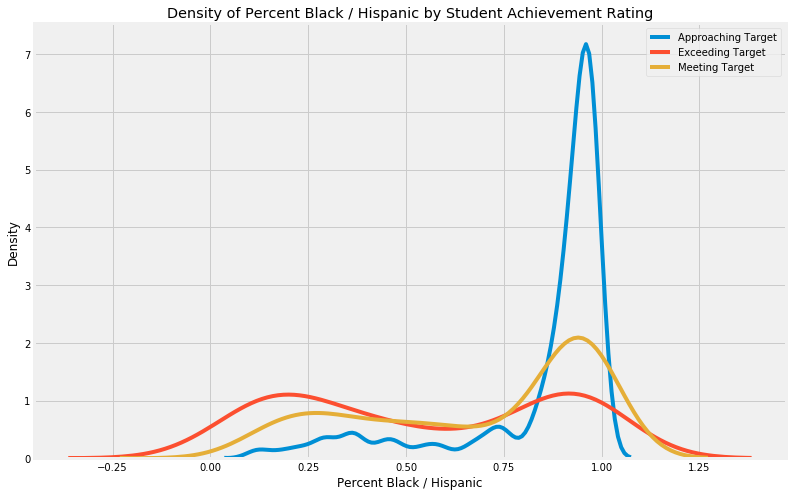

In [20]:
# Density Plots by Student Achievement Rating after changing the Not Meeting Target value

density_plot(data, 'Economic Need Index')
density_plot(data, 'School Income Estimate')
density_plot(data, 'Percent Black / Hispanic')

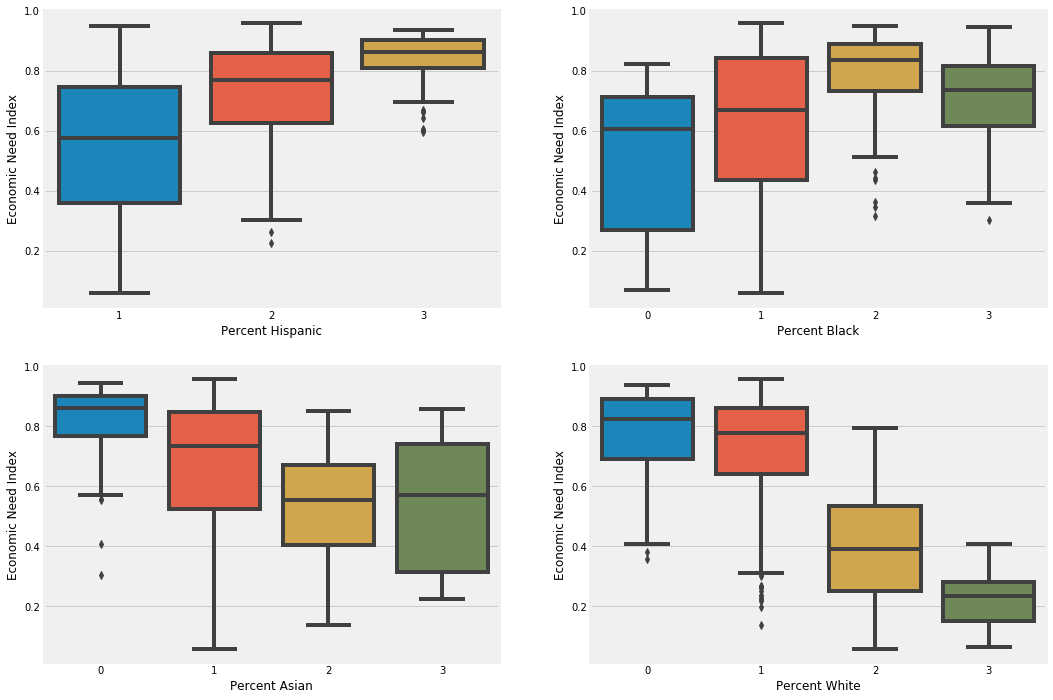

In [21]:
# Boxplots - by Features

fig, ax = plt.subplots(2, 2, figsize = (16, 12))
sns.boxplot('Percent Hispanic','Economic Need Index', data = data, ax = ax[0,0])
sns.boxplot('Percent Black','Economic Need Index', data = data, ax = ax[0,1])
sns.boxplot('Percent Asian','Economic Need Index', data = data, ax = ax[1,0])
sns.boxplot('Percent White','Economic Need Index', data = data, ax = ax[1,1]);

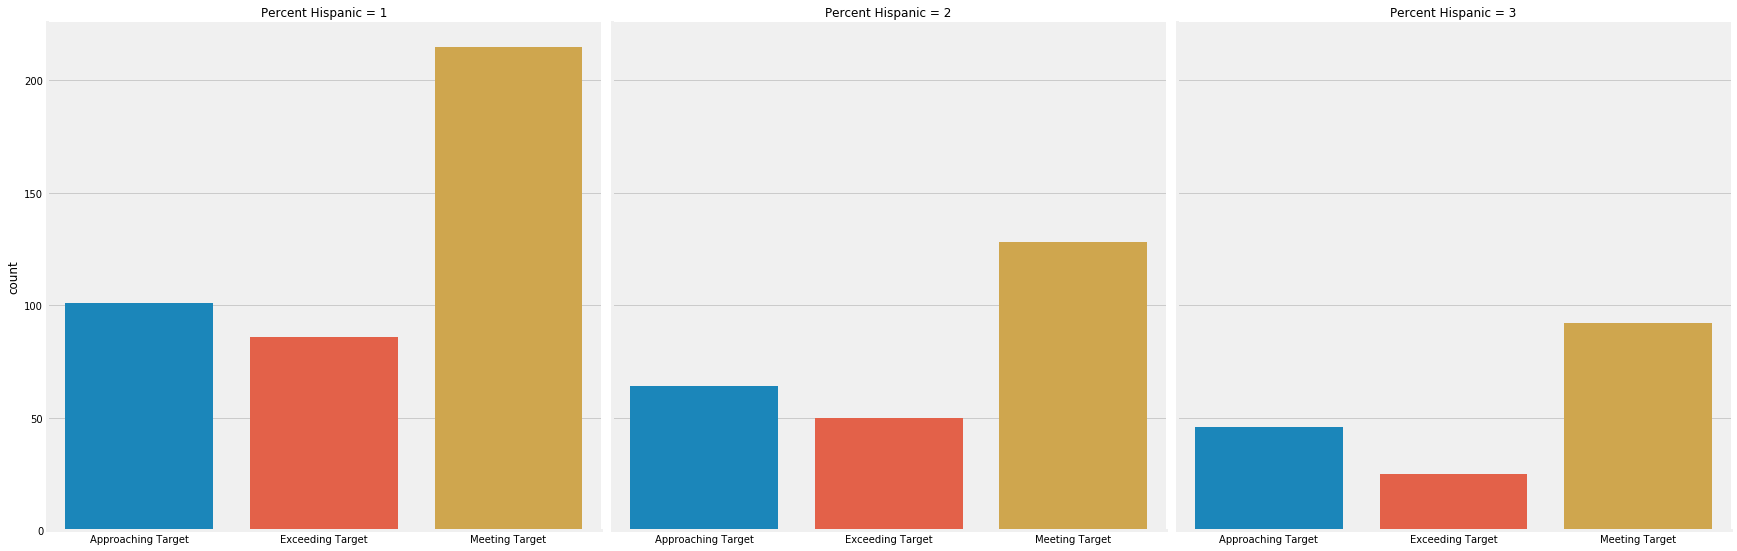

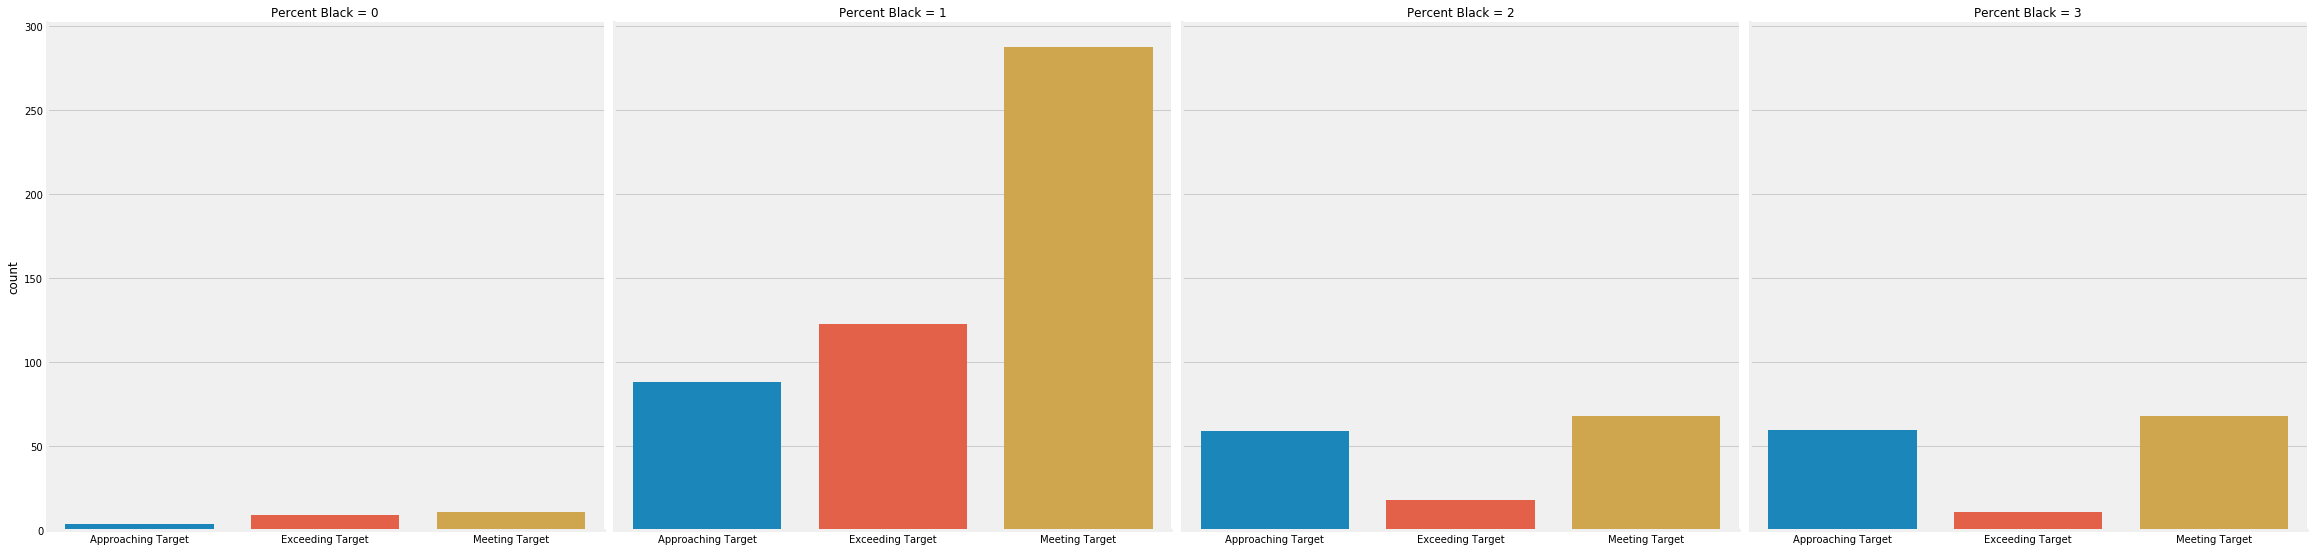

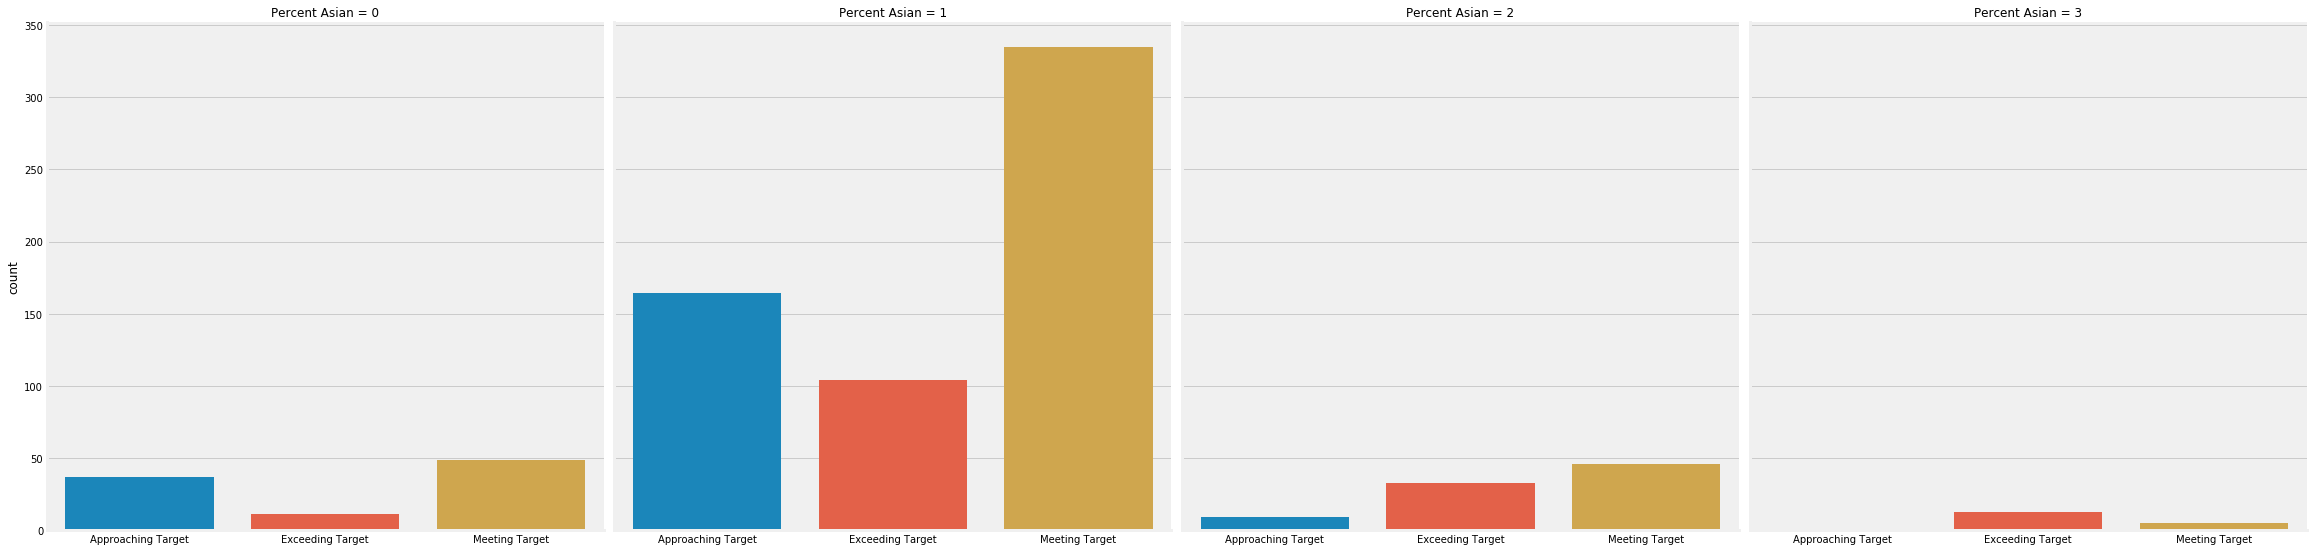

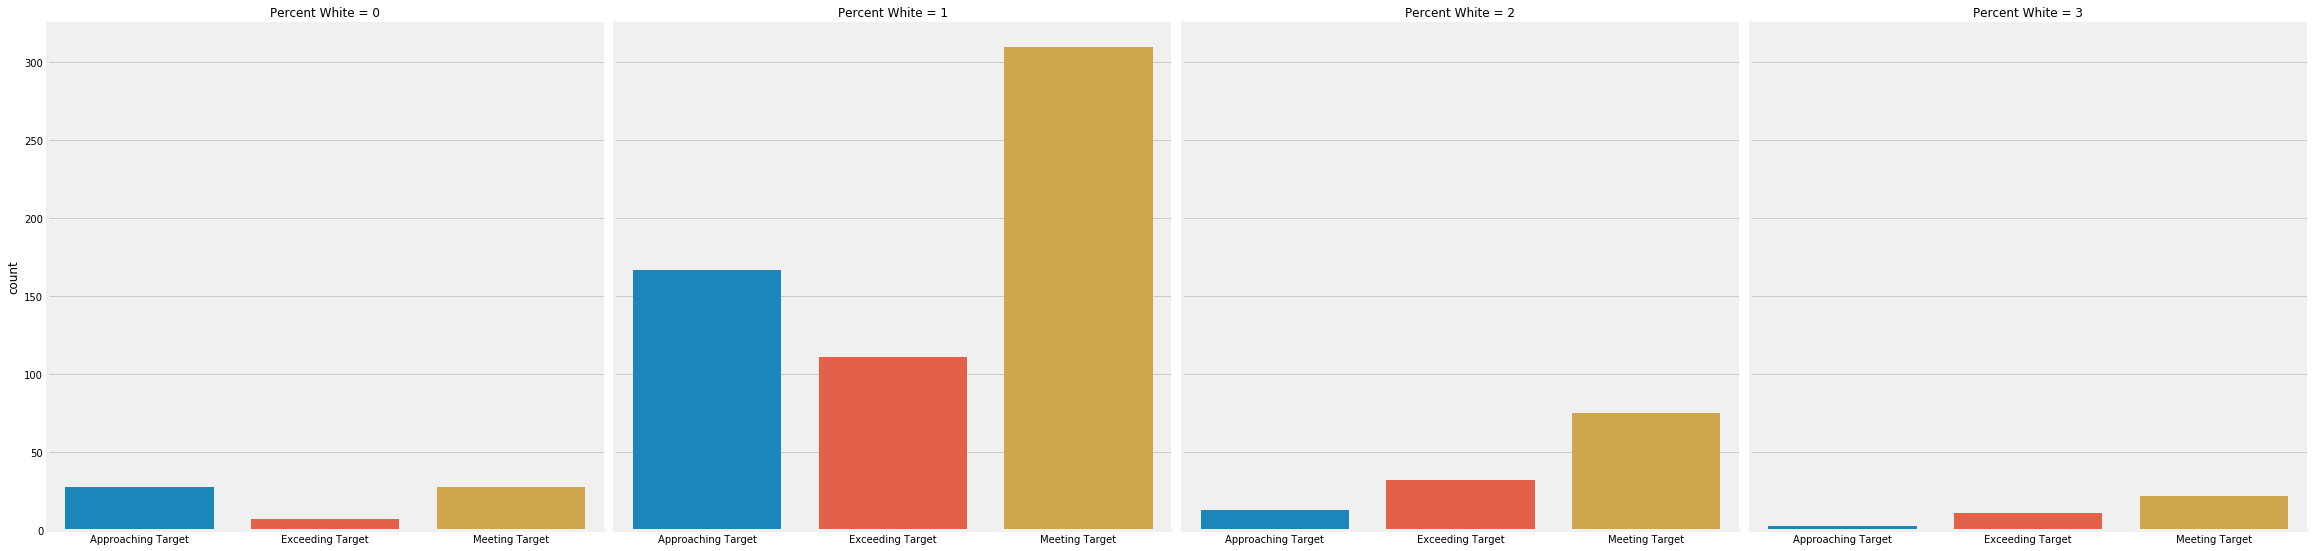

In [22]:
# Factor Plots - Student achievement rating by race

sns.factorplot('Student Achievement Rating', col='Percent Hispanic', 
               data=data.sort_index(), kind="count", size = 8).set(xlabel='')
sns.factorplot('Student Achievement Rating', col='Percent Black', 
               data=data.sort_index(), kind="count", size = 8).set(xlabel='')
sns.factorplot('Student Achievement Rating', col='Percent Asian', 
               data=data.sort_index(), kind="count", size = 8).set(xlabel='')
sns.factorplot('Student Achievement Rating', col='Percent White', 
               data=data.sort_index(), kind="count", size = 8).set(xlabel='');

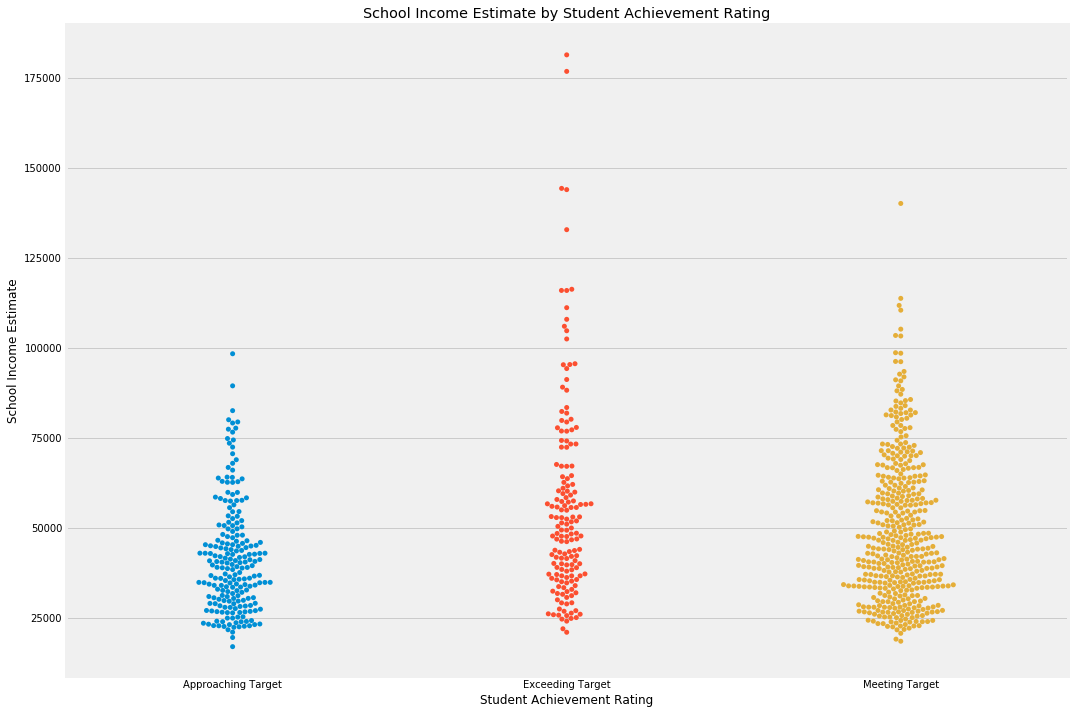

In [23]:
# Distribution of School Income Estimate by Student Achievement Rating

fig, ax = plt.subplots(figsize = (16, 12))
sns.swarmplot(x = 'Student Achievement Rating', y = 'School Income Estimate', data=data)
ax.set_title('School Income Estimate by Student Achievement Rating');

In [24]:
# Create values for target (and all ratings features)

d = {'Exceeding Target': 3, 'Meeting Target': 2, 'Approaching Target': 1}

for feat in rating_features:
    data[feat] = data[feat].map(d)

In [25]:
# Select the final features (I did not include features that included the number of test takers)

final = data[['Student Achievement Rating','School Name', 'SED Code','Economic Need Index', 'School Income Estimate', 
         'Community School?', 'Percent ELL','Percent Asian', 'Percent Black','Percent Hispanic','Percent White','Student Attendance Rate',
         'Percent of Students Chronically Absent','Rigorous Instruction Rating','Collaborative Teachers Rating',
         'Supportive Environment Rating','Effective School Leadership Rating','Strong Family-Community Ties Rating',
         'Trust Rating','Rigorous Instruction %','Collaborative Teachers %',
         'Supportive Environment %','Effective School Leadership %','Strong Family-Community Ties %',
         'Trust %','Average ELA Proficiency','Average Math Proficiency']]

In [26]:
# Final check for missing values

null_values = pd.DataFrame(final.isnull().sum()).rename(columns = {0: 'Total'})
null_values['Percent'] = null_values['Total'] / len(final)
null_values = null_values.sort_values(['Percent'], ascending=False)
null_values.head(15)

,Total,Percent
Student Achievement Rating,0,0.0
Collaborative Teachers Rating,0,0.0
Average ELA Proficiency,0,0.0
Trust %,0,0.0
Strong Family-Community Ties %,0,0.0
Effective School Leadership %,0,0.0
Supportive Environment %,0,0.0
Collaborative Teachers %,0,0.0
Rigorous Instruction %,0,0.0
Trust Rating,0,0.0


In [27]:
final.head()

,Student Achievement Rating,School Name,SED Code,Economic Need Index,School Income Estimate,Community School?,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,...,Strong Family-Community Ties Rating,Trust Rating,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %,Average ELA Proficiency,Average Math Proficiency
0,1,P.S. 015 ROBERTO CLEMENTE,310100010015,0.919,31141.72,0,1,1,1,2,...,2,3,0.89,0.94,0.86,0.91,0.85,0.94,2.14,2.17
1,3,P.S. 019 ASHER LEVY,310100010019,0.641,56462.88,1,1,1,1,2,...,2,2,0.96,0.96,0.97,0.90,0.86,0.94,2.63,2.98
2,1,P.S. 020 ANNA SILVER,310100010020,0.744,44342.61,1,1,2,1,2,...,1,1,0.87,0.77,0.82,0.61,0.80,0.79,2.39,2.54
3,3,P.S. 034 FRANKLIN D. ROOSEVELT,310100010034,0.860,31454.00,1,1,1,1,2,...,2,2,0.85,0.78,0.82,0.73,0.89,0.88,2.48,2.47
4,2,THE STAR ACADEMY - P.S.63,310100010063,0.730,46435.59,1,1,1,1,2,...,2,2,0.90,0.88,0.87,0.81,0.89,0.93,2.38,2.54


In [28]:
# Model Selection and Testing

metric = make_scorer(f1_score, greater_is_better=True, average = 'micro')

train, test = train_test_split(final, test_size=0.25, random_state=50)

x_train = train.drop(columns = ['SED Code','School Name','Student Achievement Rating'])
y_train = train[['Student Achievement Rating']]

x_test = test.drop(columns = ['SED Code','School Name','Student Achievement Rating'])
y_test = test[['Student Achievement Rating']]


features = list(x_train.columns)
pipe = Pipeline([('imputer', Imputer(strategy = 'median')), ('scaler', MinMaxScaler())])


train_x = pipe.fit_transform(x_train)
test_x = pipe.transform(x_test)


### Create a 
model_df = pd.DataFrame(columns = ['Model', 'Score (Micro F1)', 'Standard Dev'])

def models(train, train_labels, model, name, model_df=None):
    """Perform 10 fold cross validation of a model"""
    scores = cross_val_score(model, train, train_labels, cv = 15, scoring=metric)
    if model_df is not None:
        model_df = model_df.append(pd.DataFrame({'Model': name, 'Score (Micro F1)': scores.mean(), 
                                                 'Standard Dev': scores.std()}, index = [0]),ignore_index = True)

        return model_df

    
model_df = models(train_x, y_train, LinearSVC(), 'LSVC', model_df)
model_df = models(train_x, y_train, GaussianNB(), 'GNB', model_df)
model_df = models(train_x, y_train, LinearDiscriminantAnalysis(), 'LDA', model_df)
model_df = models(train_x, y_train,RandomForestClassifier(150, random_state = 15), 'RF', model_df)
model_df.sort_values(by = 'Score (Micro F1)', ascending = False)

,Model,Score (Micro F1),Standard Dev
2,LDA,0.659419,0.059541
3,RF,0.621329,0.059244
0,LSVC,0.614634,0.057424
1,GNB,0.389709,0.032066


In [29]:
model = RandomForestClassifier(150, random_state=15)
model.fit(train_x, y_train)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
feature_importances

,Feature,Importance
0,Economic Need Index,0.090548
1,School Income Estimate,0.080988
2,Community School?,0.002518
3,Percent ELL,0.009034
4,Percent Asian,0.019753
5,Percent Black,0.022342
6,Percent Hispanic,0.021830
7,Percent White,0.019137
8,Student Attendance Rate,0.000678
9,Percent of Students Chronically Absent,0.009979


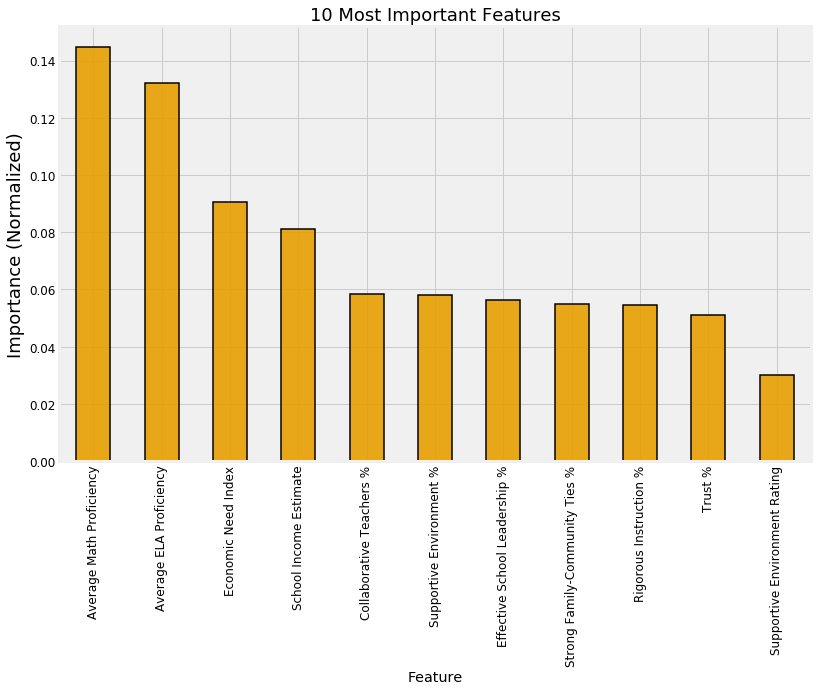

In [30]:
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255], 
          [213/255,94/255,0], [0,114/255,178/255]]

def plot_importances(dataset, n = 10, threshold = None):
    dataset = dataset.sort_values('Importance', ascending = False).reset_index(drop = True)
    dataset['normalized_imp'] = dataset['Importance'] / dataset['Importance'].sum()
    dataset['cumulative_imp'] = np.cumsum(dataset['normalized_imp'])
    plt.rcParams['font.size'] = 12
    dataset.loc[:n, :].plot.bar(y = 'normalized_imp', 
                            x = 'Feature', color = colors[1],
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 1.5)
    plt.ylabel('Importance (Normalized)', size = 18); 
    plt.title('{} Most Important Features'.format(n),size = 18)

    return dataset

plot = plot_importances(feature_importances, threshold=0.95)

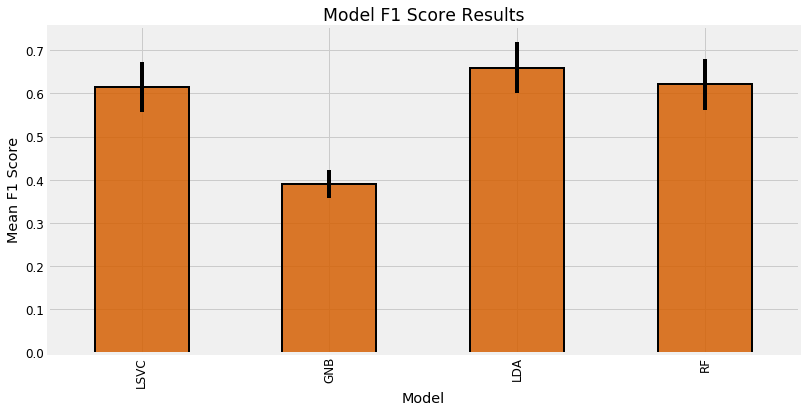

In [31]:
model_df.set_index('Model', inplace = True)
model_df['Score (Micro F1)'].plot.bar(color = colors[4], figsize = (12, 6),
                                  yerr = list(model_df['Standard Dev']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score');
model_df.reset_index(inplace = True)

In [32]:
model = LinearDiscriminantAnalysis()
model.fit(train_x, y_train)
pred = model.predict(test_x)
pred = pd.DataFrame({'Predictions': pred, 'School': test['School Name']})
pred.head()

,Predictions,School
1091,2,P.S. 075 MAYDA CORTIELLA
467,1,P.S. 305 DR. PETER RAY
37,1,P.S. 111 ADOLPH S. OCHS
413,2,P.S. 047 JOHN RANDOLPH
627,2,P.S. 224 HALE A. WOODRUFF


In [33]:
pred['Predictions'].value_counts()

2    119
3     42
1     41
Name: Predictions, dtype: int64

In [34]:
train['Student Achievement Rating'].value_counts()

2    320
1    168
3    117
Name: Student Achievement Rating, dtype: int64

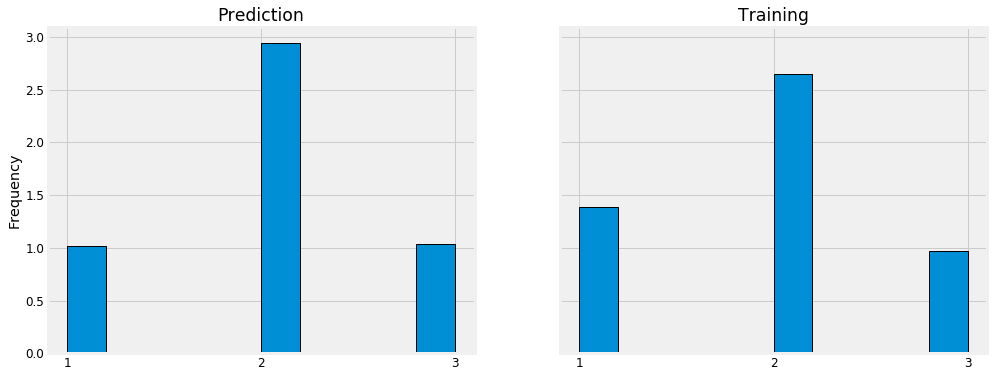

In [35]:
fig, ax = plt.subplots(1, 2, sharey = True, figsize = (15, 6))
pred['Predictions'].sort_index().plot.hist(normed = True, edgecolor = r'k',linewidth = 1, ax = ax[0])
ax[0].set_xticks([1, 2, 3])
ax[0].set_title('Prediction')
train['Student Achievement Rating'].sort_index().plot.hist(normed = True, edgecolor = r'k', linewidth = 1, ax = ax[1])
ax[1].set_xticks([1, 2, 3])
ax[1].set_title('Training');